<a href="https://colab.research.google.com/github/pepetonof/IC-ENC-2024/blob/main/tutorial_IC_ENC2024_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np

# Obtiene el Conjunto de Datos

In [ ]:
def get_data(dataset):
  transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(1),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     #transforms.Normalize((0.5,), (0.5,), (0.5))
     ])

  #MNIST (60,000 train + 10,000 test)
  if dataset == 'MNIST':
    batch_size = 60000
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    images_train, labels_train = next(iter(trainloader))

    batch_size = 10000
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=1)
    images_test, labels_test = next(iter(testloader))

    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

  #FMNIST (60,000 train + 10,000 test)
  elif dataset == "FMNIST":
    batch_size = 10000 #60000
    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    images_train, labels_train = next(iter(trainloader))

    batch_size = 10000
    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=1)
    images_test, labels_test = next(iter(testloader))

    classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle-boot')

  data = {}
  data["train_images"] = images_train
  data["train_labels"] = labels_train

  data["test_images"] = images_test
  data["test_labels"] = labels_test

  dataloaders = {}
  dataloaders["train"] = trainloader
  dataloaders["test"] = testloader

  return data, dataloaders, classes

In [ ]:
data, dataloaders, classes = get_data('FMNIST')
trainloader = dataloaders['train']
testloader = dataloaders['test']

train_images = data["train_images"]
train_labels = data["train_labels"]

test_images = data["test_images"]
test_labels = data["test_labels"]

In [ ]:
#Función para obtener un conjunto de datos balanceado en clases
def get_data_balanced(images, labels, no_examples_per_class):
  #Conforma vector de píxeles
  images_t = images.flatten(start_dim=1)

  #Genera diccionarcio
  def mk_dict_balance(no_examples, no_classes):
    dic={}
    for i in range(no_classes):
      dic[i]=no_examples
    return dic

  #A partir de un vector devuelve una imagen de tamaño "size como tupla"
  def vector2img(vector, size):
    ch=3 if vector.shape[1]%3==0 else 1
    return vector.view(len(vector), ch, size[0], size[1])

  #Genera dataset balanceado
  balanced = mk_dict_balance(no_examples_per_class, 10)
  under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=balanced)#"auto"
  X_res, y_res = under_sampler.fit_resample(images_t, labels)
  #print(Counter(y_res))

  #Recupera formato de tensor [B C H W]
  size = (images.shape[2], images.shape[3])
  images_balanced = vector2img(torch.from_numpy(X_res), size)
  labels_balanced = torch.from_numpy(y_res)

  return images_balanced, labels_balanced

In [ ]:
#Obtiene un dataset balanceado: 80 imágenes por clase para entrenamiento y 20 por clase para prueba
train_images, train_labels = get_data_balanced(train_images, train_labels, 80)
test_images, test_labels = get_data_balanced(test_images, test_labels, 20)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(torch.Size([800, 1, 28, 28]),
 torch.Size([800]),
 torch.Size([200, 1, 28, 28]),
 torch.Size([200]))

In [ ]:
#Funciones para mostrar una imagen
def vector2img(vector, size):
  ch=3 if vector.shape[1]%3==0 else 1
  return vector.view(len(vector), ch, size[0], size[1])

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

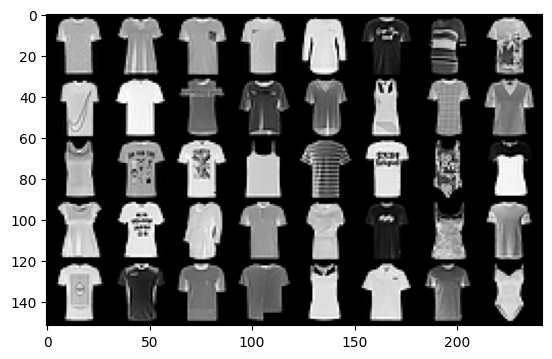

In [ ]:
grid = torchvision.utils.make_grid(train_images[:40], nrow = 8, padding = 2)
imshow(grid)

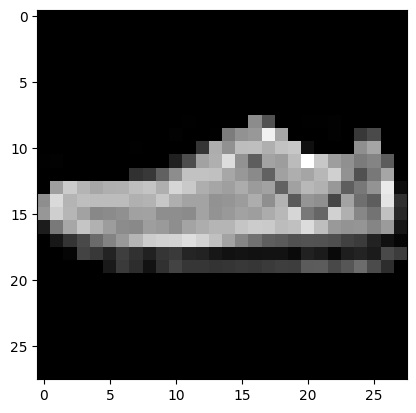

sneaker


In [ ]:
# Muestra un ejemplo de la imagen que compone el conjunto de datos
idx=600
grid=torchvision.utils.make_grid(train_images[idx,:,:,:])
imshow(grid)
print(classes[train_labels[idx]])

# Convolucion discreta en imágenes
La figura muestra una convolución de un filtro o kernel de convolución de *3x3* sobre una imagen de *4x4*.

Notar que las dimensiones se reducen y no es posible aplicar la convolución en los píxeles de todos los bordes

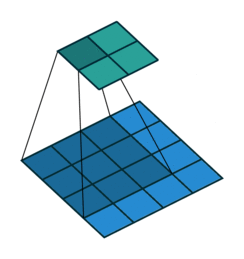

Para evitar la reducción de las dimensiones, usualmente se utiliza un padding que permite aplicar los filtros de 3x3 a cada uno de los filtros. Note que la salida mantiene las dimensiones.

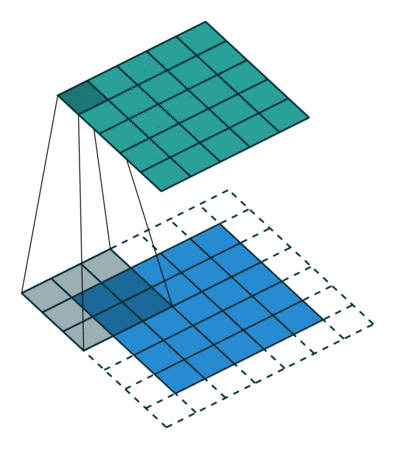

#Modelo CNN

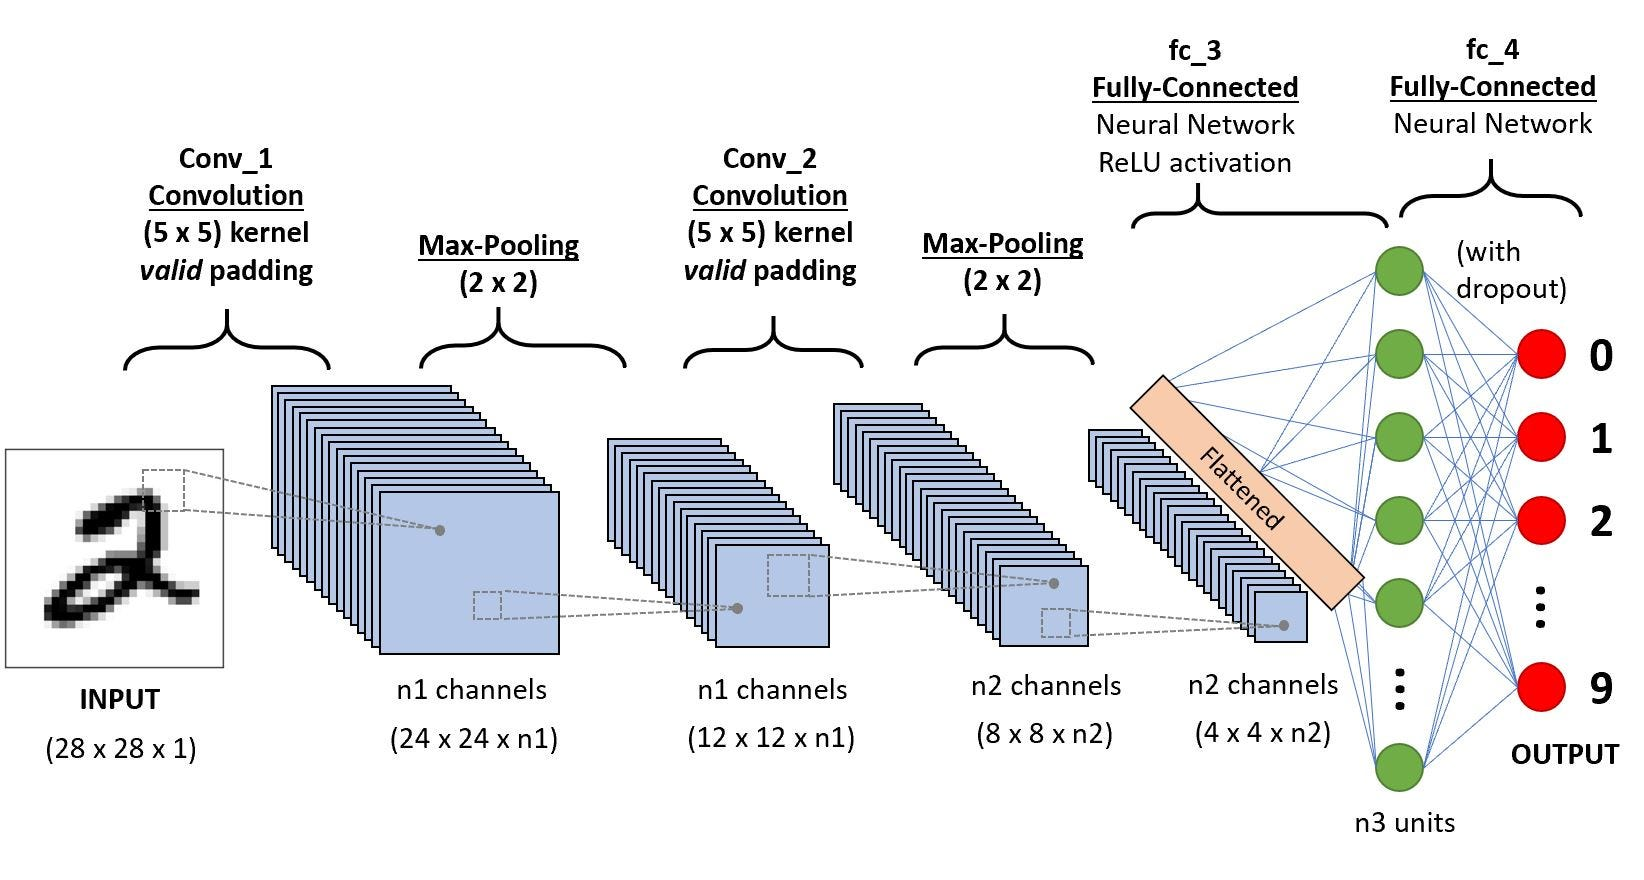

In [ ]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()

        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # Output: [batch_size, 32, 26, 26]
        self.relu = nn.ReLU()
        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # Output: [batch_size, 64, 11, 11]

        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 32, 13, 13]

        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 64, 5, 5]

        #
        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model  = basicCNN().to(device)

#Optimizer and criteria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Number of complete passes through the dataset
num_epochs = 40

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Iterate over each batch of the training data
    for images, labels in trainloader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Clear the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)

        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()

        # Update the model parameters
        optimizer.step()

    print(f"Epoch: {epoch} \t Loss: {loss}")

Epoch: 0 	 Loss: 0.5563178062438965
Epoch: 1 	 Loss: 0.5379216074943542
Epoch: 2 	 Loss: 0.5265711545944214
Epoch: 3 	 Loss: 0.5170074701309204
Epoch: 4 	 Loss: 0.5074477791786194
Epoch: 5 	 Loss: 0.49539557099342346
Epoch: 6 	 Loss: 0.48152288794517517
Epoch: 7 	 Loss: 0.46910223364830017
Epoch: 8 	 Loss: 0.4595682621002197
Epoch: 9 	 Loss: 0.45182010531425476
Epoch: 10 	 Loss: 0.44469383358955383
Epoch: 11 	 Loss: 0.4379618763923645
Epoch: 12 	 Loss: 0.43184515833854675
Epoch: 13 	 Loss: 0.4263773560523987
Epoch: 14 	 Loss: 0.421370267868042
Epoch: 15 	 Loss: 0.4166772961616516
Epoch: 16 	 Loss: 0.4121156334877014
Epoch: 17 	 Loss: 0.4073980748653412
Epoch: 18 	 Loss: 0.40218743681907654
Epoch: 19 	 Loss: 0.3967859447002411
Epoch: 20 	 Loss: 0.391886830329895
Epoch: 21 	 Loss: 0.38732847571372986
Epoch: 22 	 Loss: 0.38113731145858765
Epoch: 23 	 Loss: 0.37480804324150085
Epoch: 24 	 Loss: 0.37254706025123596
Epoch: 25 	 Loss: 0.36825031042099
Epoch: 26 	 Loss: 0.36486494541168213
Epo

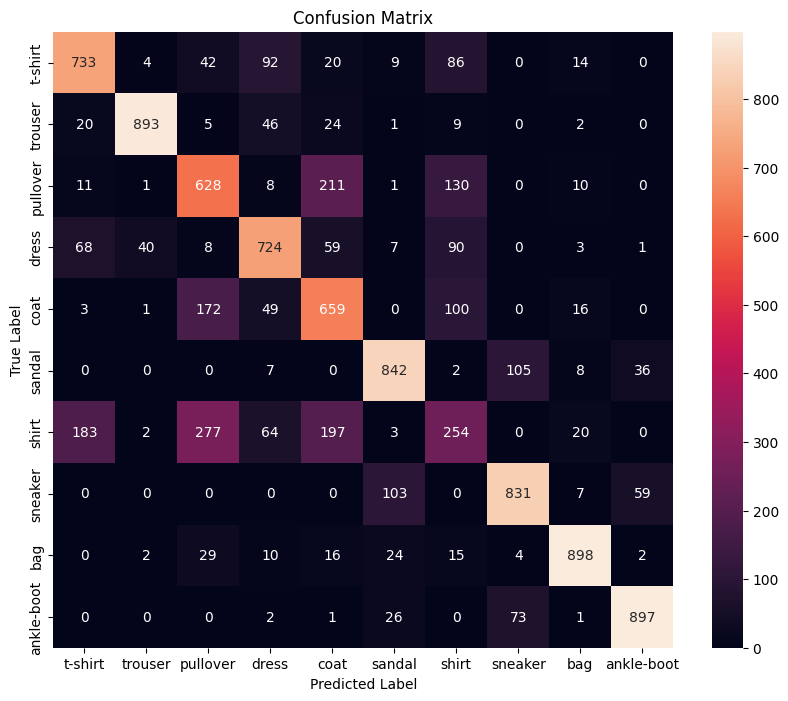

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()
_predicciones = []
_labels = []
with torch.no_grad():
  model = model.to(device)

  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    _predicciones.extend(predicted.cpu().numpy())
    _labels.extend(labels.cpu().numpy())

#confusion matrix
cm = confusion_matrix(labels, _predicciones)
# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",# cmap=plt.cm.Heat,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot